## Notes
We cannot use the resnet on its won to detect mulitple wind turbines in an image. We need to use a network which can detect many objects in one image. For example:
* YOLO
* Faster R-CNN
* SSD

After some research YOLO seems to have the best combination between speed, accuracy and ease of implementation. Speed is especially important since we want to search large areas quickly

We also have a problem. We have single images with wind turbines. However, we want to be able to search images with multiple turbines. we will try 2 approaches.


1. Use images of single turbines, output the saliency map and use it to find a bounding box. Then when training yolo, we put together images of many turbines to make the model think it is one big image with many turbines.
2. If this does not work, we output a zoomed out image of wind turbines that will likely contain many turbines. We put a bounding box aroudn each area of high activaitons and use that as input into the YOLO net



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/cs231data/
import pandas as pd
!pip install tqdm


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
from PIL import Image


In [ ]:
#get the link to the data folder
data_dir = '/content/drive/My Drive/cs231data/data/'

#Training the model (run this to train the classification model initially)

In [ ]:
#divide the data images into training and validation set, this part is for the training set
img_height,img_width=512,512
batch_size=32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory=data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 704 files belonging to 2 classes.
Using 493 files for training.


In [ ]:
#divide the data images into training and validation set, this part is for the validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)


Found 704 files belonging to 2 classes.
Using 211 files for validation.
['false', 'true']


In [ ]:
#try a parameter tuning based on the Resnet
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(512,512,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
#Resnet parameter summary
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 1)                513       
 pper)                                                           
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
__________________________________

In [ ]:
# do the resnet model compile
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=2
)


Epoch 1/2
16/16 [==============================] - 30s 1s/step - loss: 0.7805 - accuracy: 0.7120 - val_loss: 0.2110 - val_accuracy: 0.9242
Epoch 2/2
16/16 [==============================] - 13s 752ms/step - loss: 0.1708 - accuracy: 0.9452 - val_loss: 0.1188 - val_accuracy: 0.9716


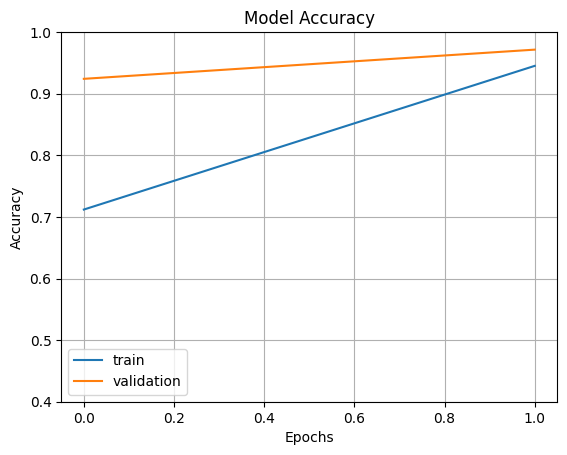

In [ ]:

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

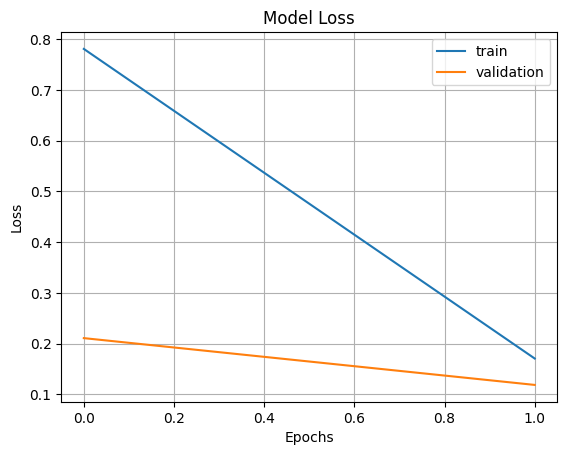

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


# Creating saliency maps (Does not need to be run) This was Shuojia's work creating saliency maps but i have changed it in my implementation

In [ ]:
_img = keras.preprocessing.image.load_img('/content/drive/My Drive/cs231data/data/true/3007073.jpg',target_size=(512,512))
plt.imshow(_img)
plt.show()

FileNotFoundError: ignored

In [ ]:
# Function that saves saliency map to drive without displaying

from tqdm import tqdm

def saliencymap(data, a):
    _img = keras.preprocessing.image.load_img(data, target_size=(512, 512))
    img = keras.preprocessing.image.img_to_array(_img)
    img = img.reshape((1, *img.shape))
    y_pred = resnet_model.predict(img)
    layers = [layer.output for layer in resnet_model.layers]
    images = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        pred = resnet_model(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    # Strip the extension from the filename before saving
    a = os.path.splitext(a)[0]
    fig, ax = plt.subplots()
    plt.imshow(grad_eval, cmap="jet", alpha=0.8)  # Only visualize the gradient map
    fig.savefig('/content/drive/My Drive/cs231data/saliency_map_v2/' + a + '.jpg')
    plt.close(fig)


In [ ]:
# Displays the saliency map images but does not save them


def com_saliencymap(data):
  _img = keras.preprocessing.image.load_img(data,target_size=(512,512))
  img = keras.preprocessing.image.img_to_array(_img)
  img = img.reshape((1, *img.shape))
  y_pred = resnet_model.predict(img)
  layers = [layer.output for layer in resnet_model.layers]
  images = tf.Variable(img, dtype=float)

  with tf.GradientTape() as tape:
      pred = resnet_model(images, training=False)
      class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
      loss = pred[0][class_idxs_sorted[0]]

  grads = tape.gradient(loss, images)
  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

  fig, axes = plt.subplots(1,2,figsize=(14,5))
  axes[0].imshow(_img)
  i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
  fig.colorbar(i)

In [ ]:
import os
def get_image_names(folder_path):
    image_names = []
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".jpeg", ".png", ".gif")):
            image_names.append(filename)
    return image_names
image_list = get_image_names(data_dir+'true/')

In [ ]:
image_list

In [ ]:
#do a check on the first 5 maps
for name in image_list[:5]:
  com_saliencymap(data_dir+'true/'+name)

In [ ]:
for name in image_list[:10]:
   saliencymap(data_dir+'true/'+name,name)

# Creating saliency map and bounding boxes

In [ ]:
# this is to see how many images we are working with in the true folder
import os
def get_image_names(folder_path):
    image_names = []
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".jpeg", ".png", ".gif")):
            image_names.append(filename)
    return image_names
image_list = get_image_names(data_dir+'true/')
image_list
print(len(image_list))

In [ ]:
# new function to create saliency map
# this is the function that should be altered if we want to create a salency map
# ...on the output features
def create_saliency_map(data, model):
    _img = keras.preprocessing.image.load_img(data, target_size=(512,512))
    img = keras.preprocessing.image.img_to_array(_img)
    img = img.reshape((1, *img.shape))
    y_pred = model.predict(img)
    images = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        pred = model(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    return grad_eval


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# these variables are important to understand!!
# Configuration variables
NUM_IMAGES = 50  # Number of images to process
THRESHOLD_RATIO = 0.5  # Ratio for calculating the threshold for the saliency map
DISPLAY_MODE = True  # Set to True for displaying results below, False for not displaying any results but saving a file of the bounding boxes in BOUNDING_BOXES_DIR
IMAGE_DIR = '/content/drive/My Drive/cs231data/data/true'
BOUNDING_BOXES_DIR = '/content/drive/My Drive/cs231data/bounding_boxes_v1'

def load_image(path):
    # Load the image or saliency map
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def calculate_threshold(saliency_map, ratio=0.5):
    # Calculate the maximum activation value in the saliency map
    max_activation = np.max(saliency_map)

    # Calculate the threshold value to select a percentage of the maximum activation
    return ratio * max_activation


def draw_bboxes(image, bounding_boxes, saliency_map_resized):
    # Create a copy of the image to draw the bounding boxes on
    image_with_boxes = image.copy()
    saliency_map_with_boxes = saliency_map_resized.copy()

    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox

        # Only draw the bounding boxes if the values are not infinite
        if not np.isinf([x1, y1, x2, y2]).any():
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw the bounding box on the image
            cv2.rectangle(saliency_map_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw the bounding box on the saliency map

    return image_with_boxes, saliency_map_with_boxes


    return image_with_boxes, saliency_map_with_boxes

def generate_bboxes(saliency_map, threshold=0.5):
    # Normalize the saliency map
    normalized_saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    # Convert to 8-bit [0, 255]
    normalized_saliency_map_255 = (normalized_saliency_map * 255).astype(np.uint8)

    # Convert to binary map
    _, binary_map = cv2.threshold(normalized_saliency_map_255, threshold * 255, 255, cv2.THRESH_BINARY)

    # Perform dilation to merge nearby blobs
    kernel = np.ones((5, 5), np.uint8)
    binary_map = cv2.dilate(binary_map, kernel, iterations=1)

    # Find contours in the binary map
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize min and max coordinates
    min_x, min_y, max_x, max_y = np.inf, np.inf, -np.inf, -np.inf
    bounding_boxes = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        min_x, min_y = min(min_x, x), min(min_y, y)
        max_x, max_y = max(max_x, x + w), max(max_y, y + h)
        bounding_boxes.append((x, y, x + w, y + h))

    # Return the list of bounding boxes
    return bounding_boxes

def display_results(image_with_boxes, saliency_map_with_boxes):
    # Convert the saliency map to an appropriate data type and range for display
    saliency_map_normalized = saliency_map_with_boxes.astype(np.float32) / 255.0
    saliency_map_color = cv2.cvtColor(saliency_map_normalized, cv2.COLOR_GRAY2BGR)

    # Set transparency (0.5) for the saliency map
    saliency_map_with_alpha = np.concatenate((saliency_map_color, 0.5 * np.ones_like(saliency_map_color[..., :1])), axis=-1)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image with bounding box in the first subplot
    axs[0].imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title('Image with Bounding Box')

    # Display the saliency map with bounding box in the second subplot
    axs[1].imshow(saliency_map_with_alpha)
    axs[1].axis('off')
    axs[1].set_title('Saliency Map with Bounding Box')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

def main(image_list, image_dir, model, mode='display', bounding_boxes_dir=None):
    # Use tqdm for creating a progress bar
    all_bounding_boxes = []

    for i in tqdm(range(NUM_IMAGES)):
        image_name = image_list[i]

        # Construct the file path for the image
        image_path = os.path.join(image_dir, image_name)

        # Load the image
        image = load_image(image_path)

        if image is None:
            print(f"Failed to load the image. Check the path: {image_path}")
            continue

        # Generate the saliency map for the image
        saliency_map = create_saliency_map(image_path, model)

        # Normalize the saliency map
        normalized_saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

        # Calculate the threshold for activations
        threshold = calculate_threshold(normalized_saliency_map)

        # Generate bounding boxes based on saliency map
        bounding_boxes = generate_bboxes(normalized_saliency_map, threshold)

        # Only write to the bounding box file if there are bounding boxes
        if len(bounding_boxes) > 0 and mode == 'save':
            all_bounding_boxes.extend([(image_name,) + bbox for bbox in bounding_boxes])

        # Draw bounding boxes on the original image and the saliency map
        image_with_boxes, saliency_map_with_boxes = draw_bboxes(image, bounding_boxes, normalized_saliency_map)

        if mode == 'display':
            # Display results
            display_results(image_with_boxes, saliency_map_with_boxes)

    if mode == 'save':
        if bounding_boxes_dir is None:
            raise ValueError("bounding_boxes_dir must be specified in 'save' mode")

        # Save all bounding box coordinates to a single file
        with open(os.path.join(bounding_boxes_dir, 'all_bounding_boxes.txt'), 'w') as f:
            for bbox in all_bounding_boxes:
                f.write(f'{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}\n')



# Call the main function
main(image_list, IMAGE_DIR, resnet_model, mode='display' if DISPLAY_MODE else 'save', bounding_boxes_dir=BOUNDING_BOXES_DIR)
